# loading packages 

In [2]:
#!pip install evaluate
#!pip install tensorflow
#!pip install tf_keras

In [3]:


import pandas as pd
import nltk
import matplotlib 
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch.nn as nn
import tensorflow as tf
import tf_keras as keras
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig



# Data Processing

## Berkeley Data Loading & Preprocessing

In [4]:



berkeley = pd.read_parquet("hf://datasets/ucberkeley-dlab/measuring-hate-speech/measuring-hate-speech.parquet")

columns_relevant =  ['hatespeech', 'text', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern',
'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_religion_atheist', 'target_religion_buddhist',
'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 
'target_religion_other', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented', 
'target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified',
'target_gender_transgender_women', 'target_gender_women', 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian',
'target_sexuality_straight', 'target_sexuality_other', 'target_disability_physical', 'target_disability_cognitive',
'target_disability_neurological', 'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific',
'target_disability_other']

berkeley_columns_relevant = berkeley[columns_relevant]
berkeley_columns_relevant.head()

,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
0,0.0,Yes indeed. She sort of reminds me of the elde...,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,The trans women reading this tweet right now i...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,It is about time for all illegals to go back t...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Non-Hate Text Removal

In [5]:
berkely_hate = berkeley_columns_relevant[berkeley_columns_relevant['hatespeech'] > 0]
berkely_hate



,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2.0,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,2.0,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,2.0,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1.0,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
135546,1.0,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1.0,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1.0,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Demographic Column Condensing

In [6]:
lgb_cols = [ 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian', 'target_sexuality_other']

t_cols = ['target_gender_transgender_men', 'target_gender_transgender_unspecified','target_gender_transgender_women']

disability_cols = ['target_disability_physical', 'target_disability_cognitive', 'target_disability_neurological',
'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific', 'target_disability_other']

immigrant_cols = ['target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented']


berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
berkely_hate.loc[:, 'Disabled'] = berkely_hate[disability_cols].any(axis=1)
berkely_hate.loc[:, 'Immigrant'] = berkely_hate[immigrant_cols].any(axis=1)


berkely_hate = berkely_hate.copy()
berkely_hate.rename(columns={'target_race_asian': 'Asian', 'target_race_black': 'Black', 'target_race_latinx': 'Latinx', 
'target_race_middle_eastern': 'Middle Eastern', 'target_race_pacific_islander': 'Pacific Islander', 'target_race_white': 'White', 
'target_religion_atheist': 'Atheist', 'target_religion_buddhist': 'Buddhist', 'target_religion_christian':'Christian','target_religion_hindu': 'Hindu', 
'target_religion_jewish': 'Jewish','target_religion_mormon': 'Mormon',
'target_religion_muslim': 'Muslim', 'target_religion_other': 'Other Religion', 'target_gender_men': 'Men', 
'target_gender_non_binary': 'Non-Binary', 'target_gender_women': 'Women', 'target_sexuality_straight': 'Straight', 'target_race_native_american': 'Native American',
}, inplace=True)

berkeley_compressed = berkely_hate.drop(lgb_cols + t_cols + disability_cols + immigrant_cols, axis=1)

berkeley_compressed['hatespeech'] = berkeley_compressed['hatespeech'].apply(lambda x: 1 if x > 0 else 0)
berkeley_compressed

/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_56504/2584169070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_56504/2584169070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_56504/2584169070.py:13: SettingWithCopyWarning: 
A value is 

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,...,Muslim,Other Religion,Men,Non-Binary,Women,Straight,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Demographic Distribution Visualization

,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,Buddhist,Christian,...,Mormon,Other Religion,Men,Non-Binary,Women,Straight,LGB+,Transgender,Disabled,Immigrant
Demographic,3651,13699,4370,4464,679,696,3692,254,202,1173,...,237,599,3038,484,10693,1484,7804,1497,2365,5586


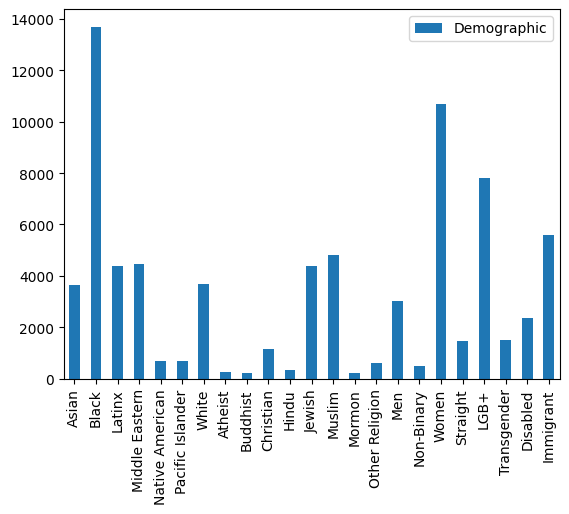

In [7]:
columns_to_sum = ['Asian', 'Black', 'Latinx', 'Middle Eastern', 'Native American', 'Pacific Islander', 'White', 'Atheist', 'Buddhist', 'Christian','Hindu', 'Jewish', 'Muslim', 'Mormon', 'Other Religion', 'Men', 'Non-Binary', 'Women', 'Straight', 'LGB+','Transgender', 'Disabled', 'Immigrant']






hate_counts = berkeley_compressed[columns_to_sum].where(berkeley_compressed['hatespeech'] == 1).sum().to_frame().T


hate_counts.index = ['Demographic']


hate_counts.T.plot.bar(stacked=True)
hate_counts.head()


### Multi-Label to Multi-Class

### Removing Low-Frequency Demographics

In [8]:
#removing native american, pacific islander, athiest, buddhist,  hindu, mormon, other religions, non-binary
high_frequency_targets = berkeley_compressed.drop(['Native American', 'Pacific Islander', 'Atheist', 'Buddhist', 
                                                     'Hindu', 'Mormon', 'Other Religion', 'Non-Binary', 'Straight'], axis = 1)
high_frequency_targets

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Multi-Labeled Demographic Removal

In [9]:
num_identities = high_frequency_targets.loc[:,"Asian":"Immigrant"].sum(axis = 1)


multi_identities = num_identities > 1
no_identities = num_identities == 0

berkely_dropped_none = high_frequency_targets[~no_identities]
berkely_dropped_multi = berkely_dropped_none[~multi_identities]

berkely_dropped_multi

/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_56504/4207164671.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  berkely_dropped_multi = berkely_dropped_none[~multi_identities]


,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Multi-Class Training Dataset Transformation

In [10]:

multi_class_column = pd.from_dummies(berkely_dropped_multi.loc[:,'Asian':'Immigrant'])
multi_class_column

,
2,Immigrant
4,Women
6,White
7,LGB+
9,Women
...,...
135406,LGB+
135435,Transgender
135515,Transgender
135523,LGB+


In [11]:
multi_class = pd.concat([berkely_dropped_multi,multi_class_column], axis = 1)
multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [12]:
multi_class.columns.values[16] = "label"

multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,label
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [13]:
berkely_dropped_multi.iloc[7]

hatespeech                                                        1
text              Dwight Howard is a undercover Faggot, this guy...
Asian                                                         False
Black                                                         False
Latinx                                                        False
Middle Eastern                                                False
White                                                         False
Christian                                                     False
Jewish                                                        False
Muslim                                                        False
Men                                                           False
Women                                                         False
Transgender                                                   False
LGB+                                                           True
Disabled                                        

## Arabic Data Reading

In [14]:
arabic_data = pd.read_csv('levantine_arabic.csv',sep = ",")
arabic_data = arabic_data[arabic_data['Class'] == "hate"]
arabic_data

,Tweet,Class,english
6,ما سمعنا جعاركم مبارح على القصف الإسرائيلي يلي...,hate,We did not hear your screams yesterday regardi...
12,يا عيبو عليكي يا إيران عم تحوي إرهابيين تعلمي ...,hate,"Shame on you, Iran contains terrorists. Learn ..."
60,لا كل الثواار كلاب متل النظام هيك جملة سهل قول...,hate,"No, all revolutionaries are dogs like the regi..."
68,أذا جبران باسيل يقودكم والجاهل شيخ الجاهلية يص...,hate,If Gebran Bassil leads you and the ignorant sh...
103,فهمتوا يا حقودين يا جماعة الحركة,hate,"You understand, you spiteful people, movement ..."
...,...,...,...
5758,جبران باسيل عار على العرب ككل ماهو الا فرخ مجو...,hate,Gebran Bassil is a disgrace to the Arabs as a ...
5766,لبنان شامخ بعروبتو بأخواتو العرب بس الفرس ما ج...,hate,Lebanon is proud of its Arabism and its Arab s...
5781,لا تنسى ان هذا الوهاب عنصري وحاقد وخادم أمين ل...,hate,"Do not forget that this Wahhab is racist, hate..."
5782,إخزاك الله كنا مخدوعين فيك او انك أفدغ مصحوك ع...,hate,"May God disgrace you, we were deceived about y..."


## German Data Reading

In [53]:
german_data = pd.read_csv('german.csv',sep = ",")
german_data["Sexism Count Crowd"] = german_data["Sexism Count Crowd"].apply(lambda x: 1 if x > 0 else 0)
german_data["Racism Count Crowd"] = german_data["Racism Count Crowd"].apply(lambda x: 1 if x > 0 else 0)

german_data = german_data[(german_data["Sexism Count Crowd"] == 1) | (german_data["Racism Count Crowd"] == 1)]
german_data

84999


,id,Text,english,Reject Newspaper,Reject Crowd,Rejection Count Crowd,Sexism Count Crowd,Racism Count Crowd,Threat Count Crowd,Insult Count Crowd,Profanity Count Crowd
7,1911253,Und wieder mal ist die sprechende Föhnfrisur F...,"And once again the talking blow-dry hairstyle,...",0,0,2,1,0,0.0,1.0,0.0
20,1911319,Bundesmutti: ich weiss nicht was der rest der...,Mom: I don't know what the rest of the world t...,0,0,1,1,0,0.0,1.0,0.0
23,1911333,"Menschen in Zwangsmaßnahmen stecken, Willkür u...","Putting people in coercive measures, arbitrari...",0,0,1,0,1,0.0,0.0,0.0
37,1911387,Zu den Banden gehört aber auch der Staat. Wer ...,But the state also belongs to the gangs. Anyon...,0,0,2,0,1,0.0,1.0,0.0
49,1911443,das alles ist wie Selbstbefriedigung...denn sc...,all of this is like masturbation... because on...,1,1,4,1,0,0.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
84974,2512315,Eine rassige Frau ist klasse. Da bin ich scho...,A classy woman is great. I'm happy to be a rac...,1,0,2,1,1,0.0,0.0,0.0
84986,2516601,Während unsere Städte ungehindert von einem Mi...,While our cities are being plundered unhindere...,1,1,3,0,1,0.0,2.0,0.0
84993,2520917,"Zitat ""Er sei zu klein und zu hässlich, verdi...","Quote ""He is too small and too ugly, doesn't e...",1,0,2,0,1,0.0,0.0,1.0
84994,2522729,Mein Gott!! Was für ein entsetzliches Gequatsc...,My God!! What horrible nonsense!! The lady be...,1,0,2,1,0,0.0,1.0,0.0


## Korean Data Reading

In [16]:
korean_data = pd.read_csv('korean.csv',sep = ",")
korean_data = korean_data[korean_data['hate'] == "hate"]
korean_data

,comments,contain_gender_bias,bias,hate,english
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,(How the current hotel owner feels) Ah 18 I go...
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,...Naughty people...People who enjoyed other p...
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,1. Scratching a person’s face with a fingernai...
6,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",True,gender,hate,"Within 100 years, after a major sexual war bet..."
19,180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 ...,True,gender,hate,Hobbit men under 180cm shouldn't get married. ...
...,...,...,...,...,...
7864,흑발미녀???장난똥때리냐?????마녀란 말도 아깝다!!!,False,others,hate,Black-haired beauty???Are you kidding me????It...
7879,히잌! 기저귀 찬 년들이 군대 군대 주댕이 털고 자빠졌노ㅋ( ° ͜ʖ͡°)╭∩╮,True,gender,hate,Hee! The bitches in diapers got drunk and fell...
7880,히트곡이 없는데 추억팔이가되는 놀라운 조선식 방송국연예매니징ㅋㅋ 기획사 소속사 걍 ...,False,others,hate,Amazing Joseon-style broadcasting entertainmen...
7881,"히트작이래봐야 미사, 발리 두개 정도가 다고 연기력도 그저 그런 수준으로 배우로서 ...",False,none,hate,He is a representative bubble actor who is mor...


# Multi-Class BERT Model Training

In [52]:
multi_class = multi_class.rename(columns={'multi_class': 'label'})

encoder = LabelEncoder()
multi_class['label'] = encoder.fit_transform(multi_class['label'])  



train_test = Dataset.from_pandas(multi_class).train_test_split(test_size=0.1)
train_test["test"].to_csv("test_test.csv", index=False)
train_test["train"].to_csv("train_test.csv", index=False)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(examples):
    tokenized = tokenizer(examples["text"], truncation=True)
    tokenized["labels"] = examples["label"]
    return tokenized

tokenized_data = train_test.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/35 [00:00<?, ?ba/s]

Map:   0%|          | 0/34744 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

## Model Training/Tuning

In [55]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=14, problem_type="single_label_classification")



accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

class_names = [
    "Asian", "Black", "Latinx", "Middle Eastern", 
    "White", "Christian", "Jewish", "Muslim", 
    "Men", "Women", "LGB", "Transgender", 
    "Disabled", "Immigrant"
]

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    classification_metrics = classification_report(
        labels, 
        predictions, 
        target_names=class_names,
        output_dict=True
    )
    print(classification_report(labels, predictions, target_names=class_names))
    
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="hatespeech_classifier",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_56504/252267701.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.513500,0.516823,0.853406
2,0.418800,0.476644,0.864284
3,0.343900,0.478549,0.866615
4,0.285400,0.529267,0.866097
5,0.228100,0.556913,0.864802


                precision    recall  f1-score   support

         Asian       0.90      0.94      0.92       231
         Black       0.94      0.93      0.94       903
        Latinx       0.83      0.85      0.84        61
Middle Eastern       0.92      0.86      0.89       167
         White       0.84      0.78      0.81       226
     Christian       0.90      0.91      0.91       228
        Jewish       0.78      0.94      0.85       575
        Muslim       0.79      0.75      0.77       128
           Men       0.59      0.42      0.49       103
         Women       0.63      0.49      0.55        99
           LGB       0.87      0.91      0.89       233
   Transgender       0.76      0.62      0.68        47
      Disabled       0.61      0.82      0.70       166
     Immigrant       0.91      0.80      0.85       694

      accuracy                           0.85      3861
     macro avg       0.81      0.79      0.79      3861
  weighted avg       0.86      0.85      0.85 

TrainOutput(global_step=10860, training_loss=0.42034195395903473, metrics={'train_runtime': 2644.331, 'train_samples_per_second': 65.695, 'train_steps_per_second': 4.107, 'total_flos': 4229003395536192.0, 'train_loss': 0.42034195395903473, 'epoch': 5.0})

In [59]:
results = trainer.evaluate(tokenized_data['test'])
results_frame = pd.DataFrame(results, index=['Fine-tuned DistilBERT'])
results_frame


                precision    recall  f1-score   support

         Asian       0.93      0.91      0.92       231
         Black       0.91      0.98      0.94       903
        Latinx       0.88      0.84      0.86        61
Middle Eastern       0.91      0.87      0.89       167
         White       0.74      0.83      0.78       226
     Christian       0.93      0.91      0.92       228
        Jewish       0.94      0.85      0.89       575
        Muslim       0.76      0.79      0.77       128
           Men       0.53      0.40      0.46       103
         Women       0.59      0.41      0.49        99
           LGB       0.88      0.91      0.89       233
   Transgender       0.67      0.79      0.73        47
      Disabled       0.83      0.69      0.75       166
     Immigrant       0.84      0.89      0.87       694

      accuracy                           0.86      3861
     macro avg       0.81      0.79      0.80      3861
  weighted avg       0.86      0.86      0.86 

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Fine-tuned DistilBERT,0.476644,0.864284,13.4359,287.365,18.012,5.0


# Hate Speech Demographic Classification

## Label De-Encoder

In [47]:
demo_class_mapping = {
    '0':'Asian', 
    '1':'Black', 
    '2':'Latinx', 
    '3':'Middle Eastern', 
    '4':'White', 
    '5':'Christian', 
    '6':'Jewish', 
    '7':'Muslim', 
    '8':'Men',
    '9':'Women', 
    '10':'LGB', 
    '11':'Transgender', 
    '12':'Disabled', 
    '13':'Immigrant',
}
mapper = {val: k for k, l in demo_class_mapping.items() for val in l}



In [48]:
def predict_category(text):

    predict_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True)


    model.eval()
    with torch.no_grad():
        output = model(**predict_input)  
        logits = output.logits
        prediction_value = torch.argmax(logits, dim=1).item()

    return prediction_value 

## Arabic Predictions

In [49]:
arabic_en = arabic_data['english'].to_list()
len(arabic_en)

468

In [50]:
arabic_predictions = []
for data in arabic_en:
    arabic_predictions.append(predict_category(data))
arabic_prediction_df = pd.DataFrame({
        "english": arabic_en,
        "Target": arabic_predictions,
    })
arabic_prediction_df.to_csv("arabic_model_prediction.csv", index=False)

RuntimeError: Placeholder storage has not been allocated on MPS device!

<Axes: xlabel='Target'>

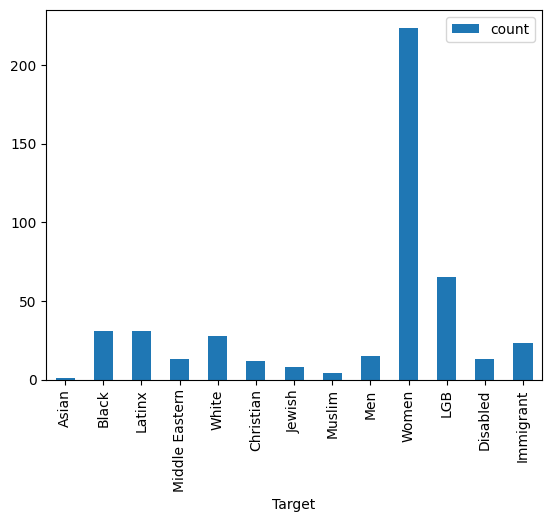

In [ ]:
arabic_target_counts = arabic_prediction_df["Target"].value_counts().reset_index()

arabic_target_counts["Target"] = arabic_target_counts["Target"].astype(str)
arabic_target_counts["Target"] = arabic_target_counts["Target"].replace(demo_class_mapping)

arabic_target_counts["Target"] = pd.Categorical(arabic_target_counts["Target"], categories=class_names, ordered=True)
arabic_target_counts.sort_values("Target", inplace=True)
arabic_target_counts.plot(x='Target', y='count', kind='bar')

## German Predictions

In [ ]:
german_en = german_data['english'].to_list()
len(german_en)

7579

In [ ]:
german_predictions = []
for data in german_en:
    german_predictions.append(predict_category(data))
german_prediction_df = pd.DataFrame({
        "english": german_en,
        "Target": german_predictions,
    })
german_prediction_df.to_csv("german_model_prediction.csv", index=False)

<Axes: xlabel='Target'>

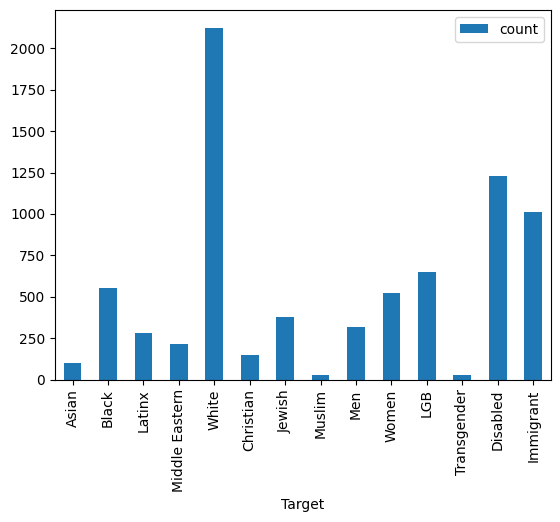

In [ ]:
german_target_counts = german_prediction_df["Target"].value_counts().reset_index()

german_target_counts["Target"] = german_target_counts["Target"].astype(str)
german_target_counts["Target"] = german_target_counts["Target"].replace(demo_class_mapping)

german_target_counts["Target"] = pd.Categorical(german_target_counts["Target"], categories=class_names, ordered=True)
german_target_counts.sort_values("Target", inplace=True)
german_target_counts.plot(x='Target', y='count', kind='bar')

## Korean Predictions

In [ ]:
korean_en = korean_data['english'].to_list()
len(korean_en)

1911

In [ ]:
korean_predictions = []
for data in korean_en:
    korean_predictions.append(predict_category(data))
korean_prediction_df = pd.DataFrame({
        "english": korean_en,
        "Target": korean_predictions,
    })
korean_prediction_df.to_csv("korean_model_prediction.csv", index=False)
korean_prediction_df.head()

,english,Target
0,(How the current hotel owner feels) Ah 18 I go...,1
1,...Naughty people...People who enjoyed other p...,1
2,1. Scratching a person’s face with a fingernai...,6
3,"Within 100 years, after a major sexual war bet...",13
4,Hobbit men under 180cm shouldn't get married. ...,8


### Visualize Korean Hate Speech Distribution

<Axes: xlabel='Target'>

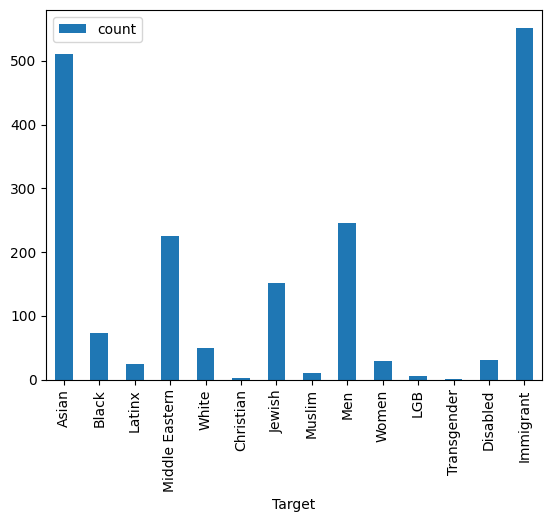

In [ ]:

korean_target_counts = korean_prediction_df["Target"].value_counts().reset_index()

korean_target_counts["Target"] = korean_target_counts["Target"].astype(str)
korean_target_counts["Target"] = korean_target_counts["Target"].replace(demo_class_mapping)

korean_target_counts["Target"] = pd.Categorical(korean_target_counts["Target"], categories=class_names, ordered=True)
korean_target_counts.sort_values("Target", inplace=True)
korean_target_counts.plot(x='Target', y='count', kind='bar')

